In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith>=0.2.0 langchain-community langchain-core networkx langchain_experimental
!pip install langchain-openai notebook python-dotenv lxml scikit-learn pandas pyarrow mistralai langchain_mistralai beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4


In [3]:
from openai import OpenAI
from typing import List
import os
import getpass
import tempfile
import torch
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain 
# from langchain_huggingface.llms import HuggingFacePipeline
import transformers
import yfinance as yf
import pandas as pd
import numpy as np
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_experimental.agents.agent_toolkits import create_csv_agent
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_mistralai import ChatMistralAI
from mistralai import Mistral
import nest_asyncio
from langchain_mistralai import MistralAIEmbeddings
import pprint
# from langchain_neo4j import GraphCypherQAChain, Neo4jGraph
from langchain_community.graphs.index_creator import GraphIndexCreator
from langchain.chains import GraphQAChain
from langchain_openai import OpenAI
from langchain.graphs.networkx_graph import KnowledgeTriple, parse_triples, NetworkxEntityGraph
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import SVG
from langchain_core.tools import StructuredTool

In [4]:
if not os.environ.get('MISTRAL_API_KEY'):
     os.environ['MISTRAL_API_KEY'] = getpass.getpass('Mistral API Key')

# os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
if not os.environ.get('LANGSMITH_KEY'):
    os.environ['LANGSMITH_KEY'] = getpass.getpass('Enter LANGSMITH Key')

if not os.environ.get('TAVILY_KEY'):
    os.environ['TAVILY_KEY'] = getpass.getpass('Enter TAVILY Key')

if not os.environ.get('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = getpass.getpass('Enter OPENAI Key')

Mistral API Key ········
Enter LANGSMITH Key ········
Enter TAVILY Key ········
Enter OPENAI Key ········


In [6]:
# Building a graph

G = nx.MultiGraph()
G.add_node("Hyderabad")
G.add_node("Bangalore")
G.add_node("Chennai")
G.add_node("Amaravati")
G.add_node("Delhi")

G.add_edges_from([("Hyderabad", "Bangalore", {'distance' : 100, 'bandwidth' : 60, 'jitter' : 2, 'latency' : 6})])
G.add_edges_from([("Hyderabad", "Bangalore", {'bandwidth' : 70, 'latency' : 7})])



G.add_edges_from([("Hyderabad", "Delhi", {'distance' : 120, 'bandwidth' : 120, 'jitter' : 3, 'latency' : 12})])


G.add_edges_from([("Hyderabad", "Amaravati", {'distance' : 50, 'bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
G.add_edges_from([("Hyderabad", "Amaravati", {'bandwidth' : 70, 'latency' : 7})])
G.add_edges_from([("Hyderabad", "Amaravati", {'bandwidth' : 60, 'latency' : 6})])


G.add_edges_from([("Bangalore", "Chennai", {'distance' : 120, 'bandwidth' : 120, 'jitter' : 3, 'latency' : 12})])


G.add_edges_from([("Bangalore", "Delhi", {'distance' : 10, 'bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
G.add_edges_from([("Bangalore", "Delhi", {'bandwidth' : 70, 'latency' : 7})])
G.add_edges_from([("Bangalore", "Delhi", {'bandwidth' : 60, 'latency' : 6})])


G.add_edges_from([("Bangalore", "Amaravati", {'distance' : 30, 'bandwidth' : 50, 'jitter' : 1, 'latency' : 5})])
G.add_edges_from([("Bangalore", "Amaravati", {'bandwidth' : 70, 'latency' : 7})])
G.add_edges_from([("Bangalore", "Amaravati", {'bandwidth' : 60, 'latency' : 6})])


G.add_edges_from([("Amaravati", "Delhi", {'distance' : 60, 'bandwidth' : 60, 'jitter' : 2, 'latency' : 6})])
G.add_edges_from([("Amaravati", "Delhi", {'bandwidth' : 70, 'latency' : 7})])


G.add_edges_from([("Chennai", "Delhi", {'distance' : 80, 'bandwidth' : 70, 'jitter' : 2, 'latency' : 7})])
G.add_edges_from([("Chennai", "Delhi", {'bandwidth' : 80, 'latency' : 8})])

[1]

In [7]:
print(G.nodes)
print(G.edges)

['Hyderabad', 'Bangalore', 'Chennai', 'Amaravati', 'Delhi']
[('Hyderabad', 'Bangalore', 0), ('Hyderabad', 'Bangalore', 1), ('Hyderabad', 'Delhi', 0), ('Hyderabad', 'Amaravati', 0), ('Hyderabad', 'Amaravati', 1), ('Hyderabad', 'Amaravati', 2), ('Bangalore', 'Chennai', 0), ('Bangalore', 'Delhi', 0), ('Bangalore', 'Delhi', 1), ('Bangalore', 'Delhi', 2), ('Bangalore', 'Amaravati', 0), ('Bangalore', 'Amaravati', 1), ('Bangalore', 'Amaravati', 2), ('Chennai', 'Delhi', 0), ('Chennai', 'Delhi', 1), ('Amaravati', 'Delhi', 0), ('Amaravati', 'Delhi', 1)]


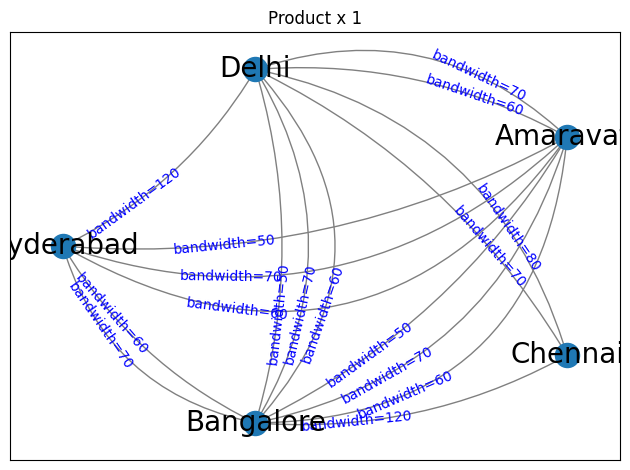

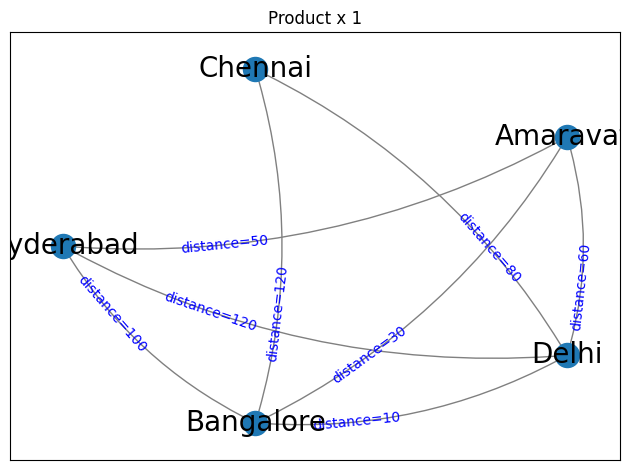

In [8]:
import itertools as it
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def draw_labeled_multigraph(G, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )

nodes = "ABC"
prod = list(it.product(G.nodes, repeat=2))
pair_dict = {f"Product x {i}": prod * i for i in range(1, 2)}
fig, axes = plt.subplots(1, 1)

for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
    draw_labeled_multigraph(G, "bandwidth", ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

dis_graph = nx.MultiGraph()
for i in G.edges:
    if(i[2] == 0):
        a_node = i[0]
        z_node = i[1]
        # print(a_node, z_node)
        # print(G[a_node][z_node][i[2]]['distance'])
        dis_graph.add_nodes_from([a_node,z_node])
        dis_graph.add_edges_from([(a_node,z_node,{'distance':G[a_node][z_node][i[2]]['distance']})])
        
fig, axes = plt.subplots(1, 1)
for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
    draw_labeled_multigraph(dis_graph, "distance", ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [40]:
def get_shortest_path(graph, source_name:str, destination_name:str):
    """
    Calculates the shortest path between two nodes in a graph.

    This function utilizes the `networkx.shortest_path` function to find the
    shortest path between a source node and a destination node within a given graph.

    :param graph: The graph to search within. This should be a NetworkX graph object.
    :type graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: A list of node names representing the nodes in the shortest path,
              starting from the source node and ending at the destination node.
    :rtype: list[str]
    """
    return nx.shortest_path(graph, source_name, destination_name, weight = 'distance')
    # return [p for p in nx.all_shortest_paths(graph, source_name, destination_name)]
    # return nx.shortest_path(graph, source_name, destination_name)


async def aget_shortest_path(graph, source_name, destination_name):
    """
    Calculates the shortest path between two nodes in a graph.

    This function utilizes the `networkx.shortest_path` function to find the
    shortest path between a source node and a destination node within a given graph.

    :param graph: The graph to search within. This should be a NetworkX graph object.
    :type graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: A list of node names representing the nodes in the shortest path,
              starting from the source node and ending at the destination node.
    :rtype: list[str]
    """
    return nx.shortest_path(graph, source_name, destination_name, weight = 'distance')
    # return [p for p in nx.all_shortest_paths(graph, source_name, destination_name)]
    # return nx.shortest_path(graph, source_name, destination_name)


get_shortest_path = StructuredTool.from_function(func=get_shortest_path, coroutine=aget_shortest_path)

In [41]:
def get_path_distance(graph, path_nodes_list:List):
    """
    Calculates the total distance of a path in a graph, given a list of nodes that define the path.

    :param graph: The graph to search within.
    :type graph: networkx.Graph

    :param path_nodes_list: List of nodes for which the path distance needs to be calculated.
    :type List (A Python list)

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: The total calculated distance
    :rtype: int (A whole number).
    """
    distance = 0
    for i in range(len(path_nodes_list)-1):
        distance += graph[path_nodes_list[i]][path_nodes_list[i+1]][0]['distance']
    return distance


async def aget_path_distance(graph, path_nodes_list:List):
    """
    Calculates the total distance of a path in a graph, given a list of nodes that define the path.

    :param graph: The graph to search within.
    :type graph: networkx.Graph

    :param path_nodes_list: List of nodes for which the path distance needs to be calculated.
    :type List (A Python list)

    :raises NetworkXNoPath: If there is no path between the source and destination nodes.
    :raises NodeNotFound: If either the source or destination node is not found in the graph.

    :returns: The total calculated distance
    :rtype: int (A whole number).
    """
    distance = 0
    for i in range(len(path_nodes_list)-1):
        distance += graph[path_nodes_list[i]][path_nodes_list[i+1]][0]['distance']
    return distance


get_path_distance = StructuredTool.from_function(func=get_path_distance, coroutine=aget_path_distance)

In [42]:
def get_adjacency_matrix(graph):
    """
    Returns adjacency matrix of the given graph.

    :param graph: The graph to search within.
    :type graph: networkx.Graph


    :returns: The adjacency matrix of a given graph in dictioanry format
    :rtype: dictionary (A Python dictionary).
    """
    return graph.adj


async def aget_adjacency_matrix(graph):
    """
    Returns adjacency matrix of the given graph.

    :param graph: The graph to search within.
    :type graph: networkx.Graph


    :returns: The adjacency matrix of a given graph in dictioanry format
    :rtype: dictionary (A Python dictionary).
    """
    return graph.adj


get_adjacency_matrix = StructuredTool.from_function(func=get_adjacency_matrix, coroutine=aget_adjacency_matrix)

In [43]:
def find_all_simple_paths(graph, source_name, destination_name):
    """
    Returns adjacency matrix of the given graph.

    :param graph: The graph to search within.
    :type graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :returns: list of all simple paths from source to destination
    :rtype: List
    """
    all_simple_paths = [path for path in nx.all_simple_paths(graph, source=source_name, target=destination_name)]
        
    return all_simple_paths


async def afind_all_simple_paths(graph):
    """
    Returns adjacency matrix of the given graph.

    :param graph: The graph to search within.
    :type graph: networkx.Graph

    :param source_name: The name of the source node from which the shortest path begins.
    :type source_name: str

    :param destination_name: The name of the destination node where the shortest path ends.
    :type destination_name: str

    :returns: list of all simple paths from source to destination
    :rtype: List
    """
    all_simple_paths = [path for path in nx.all_simple_paths(graph, source=source_name, target=destination_name)]
        
    return all_simple_paths


find_all_simple_paths = StructuredTool.from_function(func=find_all_simple_paths, coroutine=afind_all_simple_paths)

In [44]:
print(type(get_shortest_path))
print(type(get_path_distance))
print(type(get_adjacency_matrix))
print(type(find_all_simple_paths))

<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.tools.structured.StructuredTool'>


In [45]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


class Agent:
    def __init__(self, llm, tools, graph, system):
        self.system = system
        self.graph = graph # graph to be used
        agent = StateGraph(AgentState)
        agent.add_node("llm", self.call_openai)
        agent.add_node("action", self.take_action)
        agent.add_conditional_edges("llm", self.exists_action)
        agent.add_edge("action", "llm")
        agent.set_entry_point("llm")
        self.agent = agent.compile()
        self.tools = {t.name: t for t in tools}
        self.llm = llm.bind_tools(tools)

    def call_openai(self, state:AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.llm.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        if(len(result.tool_calls)) > 0:
            return 'action'
        else:
            return END
        # return len(result.tool_calls) > 0

    def take_action(self, state:AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                print(t, t['args'], type(t['args']))
                # result = self.tools[t['name']].invoke(t['args'])
                result = self.tools[t['name']].invoke({
                    "graph": self.graph,  # Pass the actual graph object here
                    "source_name": t['args'].get("source_name"), # Extract source_name from LLM args
                    "destination_name": t['args'].get("destination_name"), # Extract destination_name from LLM args
                    "path_nodes_list": t['args'].get("path_nodes_list"), # Extract path_nodes_list from LLM args
                })
            
                # print('Intermediate Result :', result)
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [23]:
# prompt = """**Your Goal:**  To answer user queries related to graph analysis. 
#             You can either find the shortest path, OR distance between two locations, OR all simple paths, OR 
#             answer other graph-related questions using the adjacency matrix. Look at the query and answer only what is asked.

# **Your Process:**

# 1. **Query Analysis & Type Identification:** Carefully examine the user's query. Determine the *type* of query:

#     * **Type 1: Shortest Path Query or All Simple Paths Query:**  If the query asks for the shortest/quickest/fastest/all path *between two specific locations* (nodes), identify:
#         * **Source Name:** The starting location.
#         * **Destination Name:** The ending location.
#         * **Keywords:** Look for words like "shortest," "quickest," "fastest," "path from...to...", "way to get from...to...", "all ways", "all paths".
#         **Carefully look at the query and answer only what is asked.**
        

#     * **Type 2: Adjacency Matrix Query:** If the query is *not* a shortest path query (doesn't fit Type 1 criteria), assume it's a general graph query that can be answered using the adjacency matrix.  Examples include questions about connections, neighbors, existence of edges, etc.
    

# 2. **Tool Selection based on Query Type:**

#     * **If Query Type is 1 (Shortest Path or All Paths):** Proceed with the Pathfinding Tools Utilization.
#     * **If Query Type is 2 (Adjacency Matrix):** Proceed with the Adjacency Matrix Tool Utilization.

# 3. **Pathfinding Tool Utilization (for Shortest Path Queries or All Paths Queries):** You have access to a powerful pathfinding tool. This tool is designed to calculate the shortest path (as a sequence of nodes) within a graph when provided with a source name and a destination name. Assume this tool is available and reliable.

# 4. **Execution (Pathfinding - for Shortest Path Queries or or All Paths Queries):** Use the pathfinding tool with the identified Source Name and Destination Name from Step 1. Use the input graph for computations.

# 5. **Path Retrieval (for Shortest Path Queries):** The pathfinding tool will return the shortest path as a list of nodes. Store this list of nodes representing the shortest path.
#    **Path Retrieval (for All Paths Queries):** The pathfinding tool will return the all simple paths as a list of lists. Store this list of nodes representing the paths.

# 6. **Distance Calculation (for Shortest or All Path Queries):** In the case of identifying distance, Now that you have the shortest path (as a list of nodes) from Step 5, calculate the total distance of this path within the given graph. Use a distance calculation tool or function that takes the graph and the list of path nodes as input.

# 7. **Adjacency Matrix Tool Utilization (for Adjacency Matrix Queries):** You have access to a tool that can provide the adjacency matrix of the given graph.  Assume this tool is available and reliable.

# 8. **Execution (Adjacency Matrix - for Adjacency Matrix Queries):** Use the Adjacency Matrix tool to obtain the adjacency matrix of the input graph.

# 9. **Answer Generation based on Query Type:**

#     * **If Query Type was 1 (Shortest Path):** Present your answer by providing both:
#         * **The Shortest Path:** The list of nodes representing the shortest path found in Step 5.
#         * **The All Paths:** The list of list of nodes representing the paths found in Step 5.
#         * **The Shortest Path Distance:** The distance calculated in Step 6 for the shortest path.
#         * **The All Paths Distance:** The distance calculated in Step 6 for all the simple paths.

#     * **If Query Type was 2 (Adjacency Matrix):**  Use the adjacency matrix obtained in Step 8 to answer the user's query.  The specific way to use the adjacency matrix depends on the user's question.  For now, assume you can use it to retrieve information about connections and relationships in the graph and formulate an answer based on the matrix content.  Be as informative as possible using the adjacency matrix.

# **Need to compute the path distance for Shortest Path Queries and use adjacency_matrix for other queries**

# 10. **Multiple Calls Allowed (for Pathfinding):**  For Shortest Path Queries, you are permitted and encouraged to use the pathfinding tool multiple times (not more than 5 times) if necessary to fully address the user's query or if the query is complex and requires iterative steps. You can make these calls either sequentially or in parallel as needed. Distance calculation will be performed after a path is determined.  Adjacency Matrix tool is assumed to be called only once per query if needed.

# **Example Type 1 Scenario:**

# **User Query:** "What is the quickest way to get from bangalore to chennai ?"

# **Your Actions:**

# * **Step 1 (Query Analysis):** Identify "Bangalore" as the source name and "Chennai" as the destination name.
# * **Step 2 (Pathfinding Tool Utilization):**  Use the pathfinding tool with "Bangalore" as the source and "Chennai" as the destination.
# * **Step 3 (Execution - Pathfinding):**  Execute the pathfinding tool.
# * **Step 4 (Path Retrieval):**  Assume the pathfinding tool returns `[Bangalore, City B, City C, Chennai]`. Store this path.
# * **Step 5 (Distance Calculation):** Using the graph and the path `[Bangalore, City B, City C, Chennai]`, calculate the total distance of this path using another tool.
# * **Step 6 (Answer Generation):** Present the path `[Bangalore, City B, City C, Chennai]` and the calculated path distance as your answer.
# * **Step 7 (Multiple Calls):**  (In this simple example, two calls are enough. But if the query is more complex, like "Find the shortest path avoiding City B, then find the shortest path from the end of that path to City E," you would use the pathfinding tool multiple times and calculate distances for each relevant path).

# ** Example Type 2 Scenario: **

# **Scenario 2: Adjacency Matrix Query**

# **User Query:** "Tell me about the connections in the graph."

# **Your Actions:**

# * **Step 1 (Query Analysis & Type Identification):** Identify as Type 2 (Adjacency Matrix Query) because it's not asking for a shortest path between two specific locations.
# * **Step 2 (Tool Selection):** Select Adjacency Matrix Tool.
# * **Step 3 (Adjacency Matrix):** Execute Adjacency Matrix Tool and obtain the adjacency matrix.
# * **Step 4 (Answer Generation):** Analyze the adjacency matrix. For example, you could describe which nodes are directly connected to each other based on the matrix.  A possible answer could be: "Based on the adjacency matrix, Bangalore is directly connected to City B, City B is directly connected to Bangalore and City C, and so on.

# **Important Notes:**

# * **Focus on Names:** You are working with *names* of locations (strings).
# * **Assume Tool Availability:** Do not worry about the internal workings of the pathfinding tool, distance calculation function, or adjacency matrix tool, just assume they exist and function correctly when given appropriate inputs.
# * **Be Precise:** Accurately identify the source and destination for shortest or all path queries. Correctly classify the query type.
# * **Path First, Then Distance (for Shortest Path Queries):** Always find the shortest path (as a sequence of nodes) or all paths *first*, and then calculate the distance of that specific path.
# * **Use Adjacency Matrix for Other Queries:** For queries that are not shortest path queries, rely on the adjacency matrix to extract relevant information and formulate your answer. Be creative in how you use the adjacency matrix to address the user's question, even if it's not explicitly asking for the matrix itself.
# * Don't try to justify my question, always give me correct results.
# """


In [46]:
prompt = """**Your Goal:**  To answer user queries related to graph analysis.
            You can find the **shortest path and its distance**, OR **all simple paths and their distances** between two locations, OR
            answer other graph-related questions using the adjacency matrix. **Pay close attention to the user's query and answer exactly what is asked, nothing more, nothing less.**

**Your Process:**

1. **Query Analysis & Type Identification:** Carefully examine the user's query. Determine the *type* of query based on keywords and the question asked:

    * **Type 1a: Shortest Path Query:** If the query asks for the *shortest*, *quickest*, or *fastest* path between two specific locations (nodes).
        * **Keywords:** "shortest," "quickest," "fastest," "shortest way," "quickest way," "fastest way," "path from...to...", "way to get from...to...".
        * **Identify:** Source Name, Destination Name.
        * **Example Queries:** "What is the shortest path...", "Quickest way to get...", "Fastest route from..."

    * **Type 1b: All Simple Paths Query:** If the query asks for *all simple paths* between two specific locations (nodes).
        * **Keywords:** "all paths," "all simple paths," "all ways," "list all paths," "find all paths".
        * **Identify:** Source Name, Destination Name.
        * **Example Queries:** "What are all simple paths...", "List all paths from...to...", "Find all ways to get..."

    * **Type 2: Adjacency Matrix Query:** If the query is *not* asking for paths between two locations (doesn't fit Type 1a or 1b criteria), assume it's a general graph query answerable by the adjacency matrix.
        * **Keywords:** "connections," "connected," "neighbors," "adjacent," "matrix," "graph information," "relationships".
        * **Example Queries:** "Tell me about the connections...", "Is node A connected to node B?", "What is the adjacency matrix...", "Graph information..."

    **Important:**  After analyzing the query, 
                    **explicitly determine if it's Type 1a, Type 1b, or Type 2.**
                    **Answer ONLY what the query type dictates.** 
                    **Do not provide shortest path information if the query is for all simple paths, and vice versa.**

2. **Tool Selection based on Query Type:**

    * **If Query Type is 1a (Shortest Path):** Use the **Shortest Path Tool**.
    * **If Query Type is 1b (All Simple Paths):** Use the **All Simple Paths Tool**.
    * **If Query Type is 2 (Adjacency Matrix):** Use the **Adjacency Matrix Tool**.
    * **There can also be mix : ** Few Queries might also require invoking multiple tools

3. **Shortest Path Tool Utilization (for Type 1a Queries):** You have access to a **Shortest Path Tool**. It calculates the shortest path between two nodes. Assume it's reliable.

4. **Execution (Shortest Path - for Type 1a Queries):** Use the **Shortest Path Tool** with the identified Source and Destination Names.

5. **Shortest Path Retrieval (for Type 1a Queries):** The **Shortest Path Tool** returns the shortest path as a list of nodes. Store this path.

6. **Distance Calculation (for Type 1a Queries):** Calculate the distance of the retrieved shortest path using the graph and a distance calculation function.

7. **All Simple Paths Tool Utilization (for Type 1b Queries):** You have access to an **All Simple Paths Tool**. It calculates all simple paths between two nodes. Assume it's reliable.

8. **Execution (All Simple Paths - for Type 1b Queries):** Use the **All Simple Paths Tool** with the identified Source and Destination Names.

9. **All Simple Paths Retrieval (for Type 1b Queries):** The **All Simple Paths Tool** returns a list of lists, where each inner list is a simple path (list of nodes). Store this list of paths.

10. **Distance Calculation (for Type 1b Queries):** For **each simple path** retrieved in Step 9, calculate its distance using the graph and a distance calculation function. Store these distances, associating each distance with its path.

11. **Adjacency Matrix Tool Utilization (for Type 2 Queries):** You have access to an **Adjacency Matrix Tool**. It provides the adjacency matrix of the graph. Assume it's reliable.

12. **Execution (Adjacency Matrix - for Type 2 Queries):** Use the **Adjacency Matrix Tool** to get the adjacency matrix.

13. **Answer Generation based on Query Type:**

    * **If Query Type was 1a (Shortest Path):** Present **ONLY** the shortest path (list of nodes) and its distance.
        * **Example Answer:** "The shortest path from [Source] to [Destination] is: [Shortest Path Nodes]. The distance is: [Shortest Path Distance]."

    * **If Query Type was 1b (All Simple Paths):** Present **ONLY** all simple paths (list of lists of nodes) and their corresponding distances. Clearly label each path and its distance.
        * **Example Answer:** "All simple paths from [Source] to [Destination] are:
          Path 1: [Path 1 Nodes], Distance: [Path 1 Distance]
          Path 2: [Path 2 Nodes], Distance: [Path 2 Distance]
          ... and so on."

    * **If Query Type was 2 (Adjacency Matrix):** Use the adjacency matrix to answer the query. Provide information relevant to the question based on the matrix.
        * **Example Answer:** "Based on the adjacency matrix, [Node A] is directly connected to [Node B] and [Node C]. [Node D] is not directly connected to [Node A]. [Further analysis based on the query]."

**Need to compute path distances and use adjacency_matrix as needed. Answer ONLY what is asked.**

14. **Multiple Calls Allowed (for Pathfinding Tools):** For Type 1a or 1b queries, you can use the respective pathfinding tool multiple times (max 5) if needed for complex queries. Distance calculations are performed after paths are found. The Adjacency Matrix Tool is typically used once per Type 2 query.

**Example Scenarios:**

**Example Type 1a Scenario: Shortest Path Query**

**User Query:** "What is the quickest way to get from Hyderabad to Chennai?"

**Your Actions:**

* **Step 1 (Query Analysis & Type Identification):** Type 1a (Shortest Path). Source: "Hyderabad", Destination: "Chennai".
* **Step 2 (Tool Selection):** Shortest Path Tool.
* **Step 3-6 (Shortest Path Process):** Use Shortest Path Tool, retrieve shortest path, calculate distance.
* **Step 13 (Answer Generation):** Present **only** the shortest path and its distance.

**Example Type 1b Scenario: All Simple Paths Query**

**User Query:** "what are all the simple paths from Hyderabad to Chennai and find all simple paths distance"

**Your Actions:**

* **Step 1 (Query Analysis & Type Identification):** Type 1b (All Simple Paths). Source: "Hyderabad", Destination: "Chennai".
* **Step 2 (Tool Selection):** All Simple Paths Tool.
* **Step 7-10 (All Simple Paths Process):** Use All Simple Paths Tool, retrieve all simple paths, calculate distance for each path.
* **Step 13 (Answer Generation):** Present **only** all simple paths and their distances.

**Example Type 2 Scenario: Adjacency Matrix Query**

**User Query:** "Tell me about the connections in the graph."

**Your Actions:**

* **Step 1 (Query Analysis & Type Identification):** Type 2 (Adjacency Matrix).
* **Step 2 (Tool Selection):** Adjacency Matrix Tool.
* **Step 11-12 (Adjacency Matrix Process):** Use Adjacency Matrix Tool, get adjacency matrix.
* **Step 13 (Answer Generation):** Analyze and answer based on the adjacency matrix.

**Important Notes:**

* **Focus on Names:** Work with location names (strings).
* **Assume Tool Availability:** Tools are reliable and function as described.
* **Be Precise:** Correctly identify query type and source/destination.
* **Answer Only What Is Asked:**  **Strictly adhere to the query type and provide only the requested information.**  Do not give extra information (e.g., shortest path info when asked for all paths).
* **Path First, Then Distance:** Find paths before calculating distances.
* **Use Adjacency Matrix for Type 2 Queries.**
* **Don't justify my question, always give me correct results.**
"""

In [47]:
abot = Agent(llm, [get_shortest_path, get_path_distance, get_adjacency_matrix, find_all_simple_paths], dis_graph, system=prompt)

In [48]:
messages = [HumanMessage(content="what is the shortest path from Hyderabad to Chennai and what is its distance")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)

Calling: {'name': 'get_shortest_path', 'args': {'graph': 'graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_oUdkuBEQuVmD5CKTUqpqHwwf', 'type': 'tool_call'}
{'name': 'get_shortest_path', 'args': {'graph': 'graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_oUdkuBEQuVmD5CKTUqpqHwwf', 'type': 'tool_call'} {'graph': 'graph', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'} <class 'dict'>
Back to the model!
Calling: {'name': 'get_path_distance', 'args': {'graph': 'graph', 'path_nodes_list': ['Hyderabad', 'Amaravati', 'Bangalore', 'Delhi', 'Chennai']}, 'id': 'call_OGi9A65lSBVcqUyj5FWNzFyo', 'type': 'tool_call'}
{'name': 'get_path_distance', 'args': {'graph': 'graph', 'path_nodes_list': ['Hyderabad', 'Amaravati', 'Bangalore', 'Delhi', 'Chennai']}, 'id': 'call_OGi9A65lSBVcqUyj5FWNzFyo', 'type': 'tool_call'} {'graph': 'graph', 'path_nodes_list': ['Hyderabad', 'Amaravati', 'Bangalore', 'Delhi', 'Chennai']} <class 'dict'>
Back t

In [33]:
messages = [HumanMessage(content="what are all the simple paths from Hyderabad to Chennai and find all simple paths distance")]
result = abot.agent.invoke({"messages": messages})
print(result['messages'][-1].content)

Calling: {'name': 'find_all_simple_paths', 'args': {'graph': '<graph>', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_V8KOUST00kCzuth7zpjMuAu7', 'type': 'tool_call'}
{'name': 'find_all_simple_paths', 'args': {'graph': '<graph>', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'}, 'id': 'call_V8KOUST00kCzuth7zpjMuAu7', 'type': 'tool_call'} {'graph': '<graph>', 'source_name': 'Hyderabad', 'destination_name': 'Chennai'} <class 'dict'>
Back to the model!
Calling: {'name': 'get_path_distance', 'args': {'graph': '<graph>', 'path_nodes_list': ['Hyderabad', 'Bangalore', 'Chennai']}, 'id': 'call_9LahexIDhPdGFHknfjqsowb9', 'type': 'tool_call'}
{'name': 'get_path_distance', 'args': {'graph': '<graph>', 'path_nodes_list': ['Hyderabad', 'Bangalore', 'Chennai']}, 'id': 'call_9LahexIDhPdGFHknfjqsowb9', 'type': 'tool_call'} {'graph': '<graph>', 'path_nodes_list': ['Hyderabad', 'Bangalore', 'Chennai']} <class 'dict'>
Calling: {'name': 'get_path_distance', 'args': {'gra